# Homework 1

In this homework, we will build a model based on real house sale data from a [Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). 

Objectives:
1. Get familar with Kaggle.com and Palmetto.
2. Assess the machine learning knwoledge and skills.


This notebook contains codes to download the dataset, build and train a baseline model, and save the results in the submission format. 

Your jobs: 
1. Implement the preprocessing code
2. Developing a better model to reduce the prediction error. You can try any models you know.
3. Submitting your results into Kaggle and take a sceenshot of your score. Then include your screenshots in this file.
4. Submit the .IPYNB file to Canvas.

## Accessing and Reading Data Sets

The competition data are separated into training and test sets. 
Each record includes the property values of the house and attributes such as street type, year of construction, roof type, basement condition. 
The data includes multiple datatypes, including integers (year of construction), discrete labels (roof type), floating point numbers, etc.. 
Some data are missing and is thus labeled `na`. 
The price of each house, namely the label, is only included in the training data set (it's a competition after all). 
The 'Data' tab on the competition tab has links to download the data.

We will read and process the data using `pandas`, an [efficient data analysis toolkit](http://pandas.pydata.org/pandas-docs/stable/). 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

### Test PyTorch installation

The output should be something similar to:
```
tensor([[0.3380, 0.3845, 0.3217],
        [0.8337, 0.9050, 0.2650],
        [0.2979, 0.7141, 0.9069],
        [0.1449, 0.1132, 0.1375],
        [0.4675, 0.3947, 0.1426]])
```

In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l

x = torch.rand(5, 3)
print(x)

tensor([[0.8561, 0.5038, 0.5001],
        [0.7731, 0.7319, 0.4826],
        [0.7384, 0.1842, 0.2368],
        [0.8588, 0.2963, 0.8355],
        [0.4255, 0.7514, 0.8812]])


We downloaded the data into the current directory. 
To load the two CSV (Comma Separated Values) files containing training and test data respectively we use Pandas.

In [3]:
!wget https://raw.githubusercontent.com/dsgiitr/d2l-pytorch/master/data/kaggle_house_pred_test.csv
!wget https://raw.githubusercontent.com//dsgiitr/d2l-pytorch/master/data/kaggle_house_pred_train.csv

--2023-02-12 01:27:44--  https://raw.githubusercontent.com/dsgiitr/d2l-pytorch/master/data/kaggle_house_pred_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451405 (441K) [text/plain]
Saving to: ‘kaggle_house_pred_test.csv.4’

kaggle_house_pred_t 100%[===================>] 440.83K  --.-KB/s    in 0.05s   

2023-02-12 01:27:44 (8.64 MB/s) - ‘kaggle_house_pred_test.csv.4’ saved [451405/451405]

--2023-02-12 01:27:44--  https://raw.githubusercontent.com//dsgiitr/d2l-pytorch/master/data/kaggle_house_pred_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent,

In [4]:
train_data = pd.read_csv('kaggle_house_pred_train.csv')
test_data = pd.read_csv('kaggle_house_pred_test.csv')

The training data set includes 1,460 examples, 80 features, and 1 label., the test data contains 1,459 examples and 80 features.

In [5]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


Let’s take a look at the first 4 and last 2 features as well as the label (SalePrice) from the first 4 examples:

In [6]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


We can see that in each example, the first feature is the ID. This helps the model identify each training example. While this is convenient, it doesn't carry any information for prediction purposes. Hence we remove it from the dataset before feeding the data into the network.

In [7]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


## Data Preprocessing

### Scaling

As stated above, we have a wide variety of datatypes. Before we feed it into a deep network we need to perform some amount of processing. Let's start with the numerical features. We begin by replacing missing values with the mean. This is a reasonable strategy if features are missing at random. To adjust them to a common scale we rescale them to zero mean and unit variance. This is accomplished as follows:

$$x \leftarrow \frac{x - \mu}{\sigma}$$

To check that this transforms $x$ to data with zero mean and unit variance simply calculate $\mathbf{E}[(x-\mu)/\sigma] = (\mu - \mu)/\sigma = 0$. To check the variance we use $\mathbf{E}[(x-\mu)^2] = \sigma^2$ and thus the transformed variable has unit variance. The reason for 'normalizing' the data is that it brings all features to the same order of magnitude. After all, we do not know *a priori* which features are likely to be relevant. Hence it makes sense to treat them equally.

You can either implement the scaling from scratch or leverage some sklearn functions.

<font color='red'> **rubic={10 points}** </font> 

In [8]:
# BEGIN YOUR CODE
from sklearn.preprocessing import StandardScaler
features = list(all_features)
numerical_features = []
categorical_features = []
size = train_data.shape
example_count = size[0]

# numerical features should have dtype of int64 or float64
for feat in features:
    series = train_data[feat]
    # print(type(series.dtype))
    if series.dtype == np.int64 or series.dtype == np.float64:
        numerical_features.append(feat)
    else:
        categorical_features.append(feat)
'''        
scaled_train_data = pd.DataFrame()
for feat in numerical_features:
    scaled_train_data = pd.concat([scaled_train_data, train_data[feat].to_frame()])
for feat in numerical_features:
    avg = train_data[feat].mean(skipna=True, numeric_only=True)
    std = train_data[feat].std(skipna=True, numeric_only=True)
    for point in range(example_count):
        if train_data.loc[point, feat] != np.nan:
            #scaled_train_data[feat][point] = (train_data[feat][point]-avg)/std
            scaled_train_data.loc[point,feat] = (train_data.loc[point,feat]-avg)/std
            
            
print(scaled_train_data.mean(skipna=True, numeric_only=True))
print(scaled_train_data.var(skipna=True, numeric_only=True))
'''
'''
for feat in numerical_features:
    avg = all_features[feat].mean(skipna=True, numeric_only=True)
    std = all_features[feat].std(skipna=True, numeric_only=True)
    for point in range(example_count):
        if train_data.loc[point, feat] != np.nan:
            all_features.loc[point,feat] = (all_features.loc[point,feat]-avg)/std
'''
num_data = all_features.select_dtypes(exclude=['object'])
sc = StandardScaler()
all_features[num_data.columns] = sc.fit_transform(num_data)

            
print(all_features.mean(skipna=True, numeric_only=True))
print(all_features.var(skipna=True, numeric_only=True))

# END YOUR CODE

MSSubClass       3.955574e-17
LotFrontage      6.424965e-17
LotArea          3.407879e-17
OverallQual     -1.667426e-16
OverallCond      3.024492e-16
YearBuilt       -5.562145e-16
YearRemodAdd     6.815758e-16
MasVnrArea       5.643123e-17
BsmtFinSF1       1.339268e-17
BsmtFinSF2       1.461020e-17
BsmtUnfSF        1.034889e-16
TotalBsmtSF     -4.870067e-18
1stFlrSF        -1.290126e-16
2ndFlrSF        -2.190779e-17
LowQualFinSF    -2.190779e-17
GrLivArea        1.436178e-16
BsmtFullBath     4.506356e-17
BsmtHalfBath    -3.288422e-17
FullBath         7.059178e-17
HalfBath        -2.555909e-17
BedroomAbvGr     2.543738e-16
KitchenAbvGr    -5.245699e-16
TotRmsAbvGrd     2.531567e-16
Fireplaces       5.355238e-17
GarageYrBlt     -3.604202e-17
GarageCars       9.740133e-17
GarageArea      -7.487728e-17
WoodDeckSF      -2.799329e-17
OpenPorchSF     -4.259849e-17
EnclosedPorch    6.694048e-17
3SsnPorch       -1.217100e-17
ScreenPorch      6.328918e-17
PoolArea         2.434199e-18
MiscVal   

### Imputation

In [9]:
# after standardizing the data all means vanish, hence we can set missing values to 0
all_features = all_features.fillna(0)

### One-hot encoding

Next we deal with discrete values. This includes variables such as 'MSZoning'. We replace them by a one-hot encoding in the same manner as how we transformed multiclass classification data into a vector of $0$ and $1$. For instance, 'MSZoning' assumes the values 'RL' and 'RM'. They map into vectors $(1,0)$ and $(0,1)$ respectively. Pandas does this automatically for us.

You can encode your data with your own implementation, pandas functions, or sklearn's functions.

<font color='red'> **rubic={10 points}** </font> 

In [10]:
# BEGIN YOUR CODE
'''
test = train_data[['MSZoning']]
test = test.fillna(test.mean(skipna=True))
test = pd.get_dummies(test, dummy_na=True)
test['MSZoning'].unique()
test
'''
'''
encoded_train_data = pd.DataFrame()
for feat in categorical_features:
    encoded_train_data = pd.concat([encoded_train_data, train_data[feat].to_frame().T])
    #df = pd.concat([df, s.to_frame().T], ignore_index=True)
encoded_train_data = encoded_train_data.transpose()
encoded_train_data = pd.get_dummies(encoded_train_data, dummy_na=True)
'''
all_features = pd.get_dummies(all_features, dummy_na=True)

all_features
# END YOUR CODE

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067331,-0.184481,-0.217879,0.646183,-0.507284,1.046258,0.896833,0.523129,0.580807,-0.29308,...,0,1,0,0,0,0,0,1,0,0
1,-0.873616,0.458190,-0.072044,-0.063185,2.188279,0.154764,-0.395604,-0.569991,1.177910,-0.29308,...,0,1,0,0,0,0,0,1,0,0
2,0.067331,-0.055946,0.137197,0.646183,-0.507284,0.980221,0.848965,0.333506,0.097856,-0.29308,...,0,1,0,0,0,0,0,1,0,0
3,0.302568,-0.398704,-0.078385,0.646183,-0.507284,-1.859351,-0.682812,-0.569991,-0.494856,-0.29308,...,0,1,0,1,0,0,0,0,0,0
4,0.067331,0.629569,0.518903,1.355551,-0.507284,0.947203,0.753229,1.382009,0.468851,-0.29308,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419700,-2.069648,-1.043937,-1.481920,1.289758,-0.043346,-0.682812,-0.569991,-0.969026,-0.29308,...,0,1,0,0,0,0,0,1,0,0
1455,2.419700,-2.069648,-1.049263,-1.481920,-0.507284,-0.043346,-0.682812,-0.569991,-0.415828,-0.29308,...,0,1,0,1,0,0,0,0,0,0
1456,-0.873616,3.885767,1.246808,-0.772552,1.289758,-0.373528,0.561757,-0.569991,1.717937,-0.29308,...,0,1,0,1,0,0,0,0,0,0
1457,0.655424,-0.313015,0.034605,-0.772552,-0.507284,0.683057,0.370284,-0.569991,-0.229233,-0.29308,...,0,1,0,0,0,0,0,1,0,0


You can see that this conversion increases the number of features from 79 to 354. Finally, via the values attribute we can extract the NumPy format from the Pandas dataframe

In [11]:
all_features.shape

(2919, 354)

## Training

To get started we train a linear model with squared loss. This will obviously not lead to a competition winning submission but it provides a sanity check to see whether there's meaningful information in the data. It also amounts to a minimum baseline of how well we should expect any 'fancy' model to work.

In [12]:
n_train = train_data.shape[0]
train_features = all_features[:n_train].values
test_features = all_features[n_train:].values
train_labels = train_data.SalePrice.values.reshape((-1, 1))

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
reg = LinearRegression()
reg.fit(train_features, train_labels)
reg.score(train_features, train_labels)

0.9332679159877325

##  Predict and Submit

Now that we know what a good choice of hyperparameters should be, we might as well use all the data to train on it (rather than just $1-1/k$ of the data that is used in the crossvalidation slices). The model that we obtain in this way can then be applied to the test set. Saving the estimates in a CSV file will simplify uploading the results to Kaggle.

In [15]:
def train_and_pred(model_name, test_features, test_data,):
    preds = reg.predict(test_features)
    # reformat it for export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv(f'{model_name}-submission.csv', index=False)

In [16]:
#train_and_pred(reg.__class__.__name__, test_features, test_data)

A file, `submission.csv` will be generated by the code above (CSV is one of the file formats accepted by Kaggle).
Next, we can submit our predictions on Kaggle and compare them to the actual house price (label) on the testing data set, checking for errors.
The steps are quite simple:

* Log in to the Kaggle website and visit the House Price Prediction Competition page.
* Click the “Submit Predictions” or “Late Submission” button on the right.
* Click the “Upload Submission File” button in the dashed box at the bottom of the page and select the prediction file you wish to upload.
* Click the “Make Submission” button at the bottom of the page to view your results.

## Try more models and more hyper-parameters

There are many machine learning models for regression.
`sklearn` offers well-developed implementations.
By tuing the hyper-parameters, you can find the model(s) with the best performance.
Please try at least 4 models and identify the relatively good hyper-parameters.
After obtaining your models, please make predictions and submit them to Kaggle.


### Model 1

<font color='red'> **rubic={10 + 10 points}** </font> 

In [17]:
# BEGIN YOUR CODE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
import warnings
warnings.filterwarnings('ignore')
train_accuracy = []
cv_accuracy = []
max_score = 0
C_vals = 10 ** np.arange(-1.5, 2, 0.5)
for C in C_vals:
    reg = LogisticRegression(max_iter=1000, C=C)
    reg.fit(train_features, train_labels.ravel())
    scores = cross_validate(reg, train_features, train_labels.ravel(), cv=5, return_train_score=True)
    cv_accuracy.append(np.mean(scores["test_score"]))
    train_accuracy.append(np.mean(scores["train_score"]))
    if np.mean(scores["test_score"]) > max_score:
        max_score = np.mean(scores["test_score"])
        best_iteration = C

reg = LogisticRegression(max_iter=1000, C=best_iteration)
reg.fit(train_features, train_labels.ravel())
best_score = reg.score(train_features, train_labels.ravel())
print(best_score)
#train_and_pred(reg.__class__.__name__, test_features, test_data)
# END YOUR CODE

0.9986301369863013


Insert your screenshot of the Kaggle result for this model.


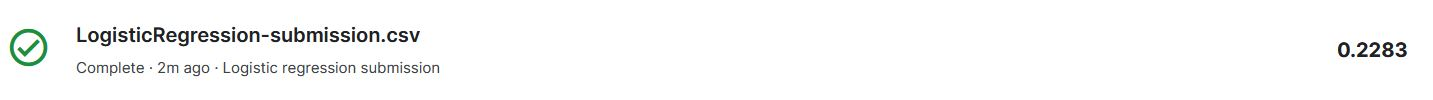

 ![](./logistic_regression.JPG)

### Model 2

<font color='red'> **rubic={10 + 10 points}** </font> 

In [18]:
# BEGIN YOUR CODE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap}

reg = RandomForestRegressor(max_depth=15, random_state=0)
reg_random = RandomizedSearchCV(estimator = reg,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=0, random_state=35, n_jobs = -1)
reg_random.fit(train_features, train_labels.ravel())

print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', reg_random.best_params_, ' \n')

reg = RandomForestRegressor(n_estimators = reg_random.best_params_['n_estimators'], 
         min_samples_split = reg_random.best_params_['min_samples_split'], 
         min_samples_leaf= reg_random.best_params_['min_samples_leaf'], 
         max_features = reg_random.best_params_['max_features'], 
         max_depth= reg_random.best_params_['max_depth'],
         bootstrap= reg_random.best_params_['bootstrap']) 
reg.fit(train_features, train_labels.ravel()) 
reg.score(train_features, train_labels.ravel())

#train_and_pred(reg.__class__.__name__, test_features, test_data)
# END YOUR CODE

Random grid:  {'n_estimators': [5, 20, 50, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 110, 'bootstrap': True}  



0.9741354747287073

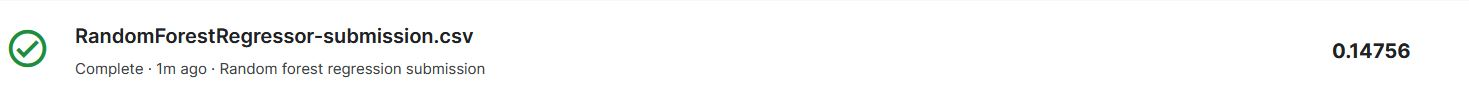

 ![](./random_forest.JPG)

### Model 3

<font color='red'> **rubic={10 + 10 points}** </font> 

In [19]:
# BEGIN YOUR CODE
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import warnings
#warnings.filterwarnings('ignore')
'''
reg = Lasso(max_iter=10000)
reg.fit(train_features, train_labels)
print(reg.score(train_features, train_labels))
'''

'''
params = {'alpha': (np.logspace(-8, 8, 100))} # It will check from 1e-08 to 1e+08
lasso = Lasso(max_iter=2000)
lasso_model = GridSearchCV(lasso, params, cv = 10)
lasso_model.fit(train_features, train_labels.ravel())
print(lasso_model.best_params_)
print(lasso_model.best_score_)
'''

alpha_space = np.logspace(-4, 4, 30)   # Checking for alpha from .0001 to 1 and finding the best value for alpha
lasso_scores = []
lasso = Lasso()
max_score = 0
best_alpha = 0
for alpha in alpha_space:
    lasso.alpha = alpha
    val = np.mean(cross_val_score(lasso, train_features, train_labels.ravel(), cv = 10))
    lasso_scores.append(val)
    if val > max_score:
        max_score = val
        best_alpha = alpha
print(max_score)
print(best_alpha)

reg = Lasso(max_iter=10000,alpha=best_alpha)
reg.fit(train_features, train_labels)
print(reg.score(train_features, train_labels))

#train_and_pred(reg.__class__.__name__, test_features, test_data)
# END YOUR CODE

0.8556626223364594
117.21022975334793
0.9126774333029883


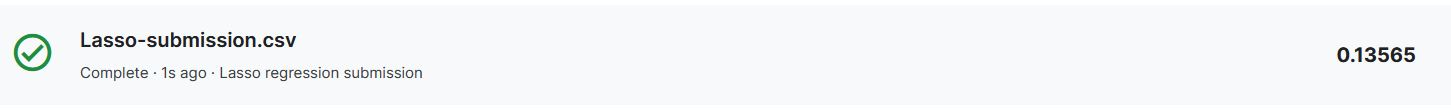

 ![](./lasso.JPG)

### Model 4

<font color='red'> **rubic={10 + 10 points}** </font> 

In [20]:
# BEGIN YOUR CODE
from sklearn.neighbors import KNeighborsRegressor
'''
reg = KNeighborsRegressor(n_neighbors=1)
reg.fit(train_features, train_labels)
reg.score(train_features, train_labels)
'''
knn = KNeighborsRegressor()
neighbors_count = np.arange(1,15,1) 
knn_scores = []
max_score = 0
best_count = 0
for neighbors in neighbors_count:
    knn.n_neighbors = neighbors
    val = np.mean(cross_val_score(knn, train_features, train_labels.ravel(), cv = 10))
    knn_scores.append(val)
    if val > max_score:
        max_score = val
        best_count = neighbors
print(max_score)
print(best_count)

reg = KNeighborsRegressor(n_neighbors=12)
reg.fit(train_features, train_labels.ravel())
reg.score(train_features, train_labels.ravel())
#train_and_pred(reg.__class__.__name__, test_features, test_data)

# END YOUR CODE

0.7899894696551999
12


0.8103316313078381

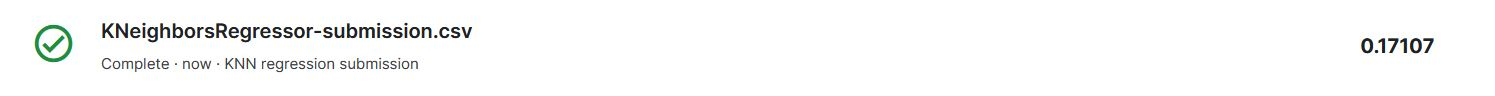

 ![](./knn.JPG)

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`.
2. Notebooks with cell execution numbers out of order will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Please keep your notebook clean and remove any throwaway code.
4. Please save this `ipynb` file and screenshots as `hw0-submission.zip`.